# 0. Install and Import Dependencies

In [31]:
# !pip list

In [32]:
# !pip install opencv-python matplotlib imageio gdown tensorflow

In [33]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [34]:
tf.config.list_physical_devices('GPU')

[]

In [35]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

# 1. Build Data Loading Functions

In [36]:
import gdown

In [37]:
# url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
# output = 'data.zip'
# gdown.download(url, output, quiet=False)
# gdown.extractall('data.zip')

In [38]:
def load_video(path:str) -> List[float]: 

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))): 
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()
    
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [39]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [40]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [41]:
char_to_num.get_vocabulary()

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [42]:
char_to_num(['n','i','c','k'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([14,  9,  3, 11])>

In [43]:
num_to_char([14,  9,  3, 11])

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'n', b'i', b'c', b'k'], dtype=object)>

In [44]:
def load_alignments(path:str) -> List[str]: 
    with open(path, 'r') as f: 
        lines = f.readlines() 
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil': 
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [106]:
def load_data(path: str): 
    path = bytes.decode(path.numpy())
    file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    # file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data_cantonese','s1',f'{file_name}.mp4')
    alignment_path = os.path.join('data_cantonese','alignment','s1',f'{file_name}.align')
    frames = load_video(video_path) 
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [46]:
test_path = './data/s1/bbal6n.mpg'

In [47]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('/')[-1].split('.')[0]

'bbal6n'

In [48]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

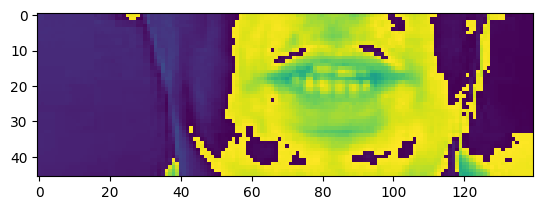

In [49]:
plt.imshow(frames[40])

In [50]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23])>

In [51]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [52]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

# 2. Create Data Pipeline

In [53]:
from matplotlib import pyplot as plt

In [54]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split 
# train = data.take(450)
# test = data.skip(450)
total_samples = 10
train_size = int(0.8 * total_samples)

# Split the data
train = data.take(train_size)
test = data.skip(train_size)

In [55]:
# for frames, target_sequence in data:
#     print("Target Sequence Length:", tf.shape(target_sequence)[1])

In [56]:
len(test)
# len(data)

492

In [57]:
file_path = "./data/alignments/s1/bras7s.align"  # Replace with the file path you want to check

if os.path.exists(file_path):
    print(f"The file '{file_path}' exists.")
else:
    print(f"The file '{file_path}' does not exist.")


The file './data/alignments/s1/bras7s.align' exists.


In [58]:
frames, alignments = data.as_numpy_iterator().next()

In [59]:
len(frames)

2

In [60]:
sample = data.as_numpy_iterator()

In [61]:
val = sample.next(); val[0]

array([[[[[1.5873265 ],
          [1.5520526 ],
          [1.5167787 ],
          ...,
          [0.49383494],
          [0.5291088 ],
          [0.5291088 ]],

         [[1.5873265 ],
          [1.5520526 ],
          [1.4462309 ],
          ...,
          [0.49383494],
          [0.5291088 ],
          [0.5291088 ]],

         [[1.4815048 ],
          [1.4815048 ],
          [1.4815048 ],
          ...,
          [0.49383494],
          [0.5291088 ],
          [0.5291088 ]],

         ...,

         [[1.0934917 ],
          [1.0934917 ],
          [1.0934917 ],
          ...,
          [0.21164355],
          [0.21164355],
          [0.21164355]],

         [[1.0934917 ],
          [1.0934917 ],
          [1.0934917 ],
          ...,
          [0.17636962],
          [0.17636962],
          [0.17636962]],

         [[1.0934917 ],
          [1.0934917 ],
          [1.0934917 ],
          ...,
          [0.17636962],
          [0.17636962],
          [0.17636962]]],


        [[[1.5873

In [62]:
imageio.mimsave('./animation.gif', val[0][0], fps=10)

Lossy conversion from float32 to uint8. Range [0.0, 8.994850158691406]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 8.994850158691406]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 8.994850158691406]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 8.994850158691406]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 8.994850158691406]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 8.994850158691406]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 8.994850158691406]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. R

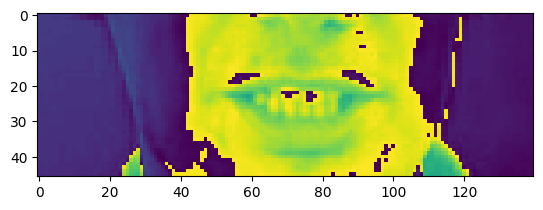

In [63]:
# 0:videos, 0: 1st video out of the batch,  0: return the first frame in the video 
plt.imshow(val[0][0][35])

In [64]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'lay white by z six please'>

In [65]:
type(val[1][0])

numpy.ndarray

In [66]:
# for word in val[1][0]:
#     print(type(word))

# 3. Design the Deep Neural Network

In [67]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import legacy
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [68]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [69]:
# def create_lip_reading_model(input_shape, num_classes):
#     model = Sequential()

#     model.add(Conv3D(128, 3, input_shape=input_shape, padding='same'))
#     model.add(Activation('relu'))
#     model.add(MaxPool3D((1, 2, 2)))

#     model.add(Conv3D(256, 3, padding='same'))
#     model.add(Activation('relu'))
#     model.add(MaxPool3D((1, 2, 2)))

#     model.add(Conv3D(75, 3, padding='same'))
#     model.add(Activation('relu'))
#     model.add(MaxPool3D((1, 2, 2)))

#     model.add(TimeDistributed(Flatten()))

#     model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
#     model.add(Dropout(0.5))

#     model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
#     model.add(Dropout(0.5))

#     model.add(Dense(num_classes, kernel_initializer='he_normal', activation='softmax'))

#     return model


In [70]:
# input_shape = (75,46,140,1)  # Modify based on your actual input shape
# num_classes =  char_to_num.vocabulary_size()+1 # Replace with the actual number of classes

In [71]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [72]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128   3584      
                             )                                   
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128   0         
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 75, 23, 70, 128)   0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                        

In [73]:
5*17*75

6375

In [74]:
yhat = model.predict(val[0])

1/1 [==============================] - 6s 6s/step


In [75]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b"neee'''''''''ffffffffffffffffffffffffffffffffffffffffffffffffff'''''''''fff">

In [76]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b"neee'''''''''ffffffffffffffffffffffffffffffffffffffffffffffffff'''''''''fff">

In [77]:
model.input_shape

(None, 75, 46, 140, 1)

In [78]:
model.output_shape

(None, 75, 41)

# 4. Setup Training Options and Train

In [79]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [80]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")
    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [81]:
class ProduceExample(tf.keras.callbacks.Callback): 
    def __init__(self, dataset) -> None: 
        self.dataset = dataset.as_numpy_iterator()
    
    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):           
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [82]:
model.compile(optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001)
, loss=CTCLoss)

In [83]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True) 

In [84]:
schedule_callback = LearningRateScheduler(scheduler)

In [85]:
example_callback = ProduceExample(test)

In [86]:
# model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

# 5. Make a Prediction 

In [132]:
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

Downloading...
From (uriginal): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y
From (redirected): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y&confirm=t&uuid=3adf67b6-63d8-4b0f-85e7-69fbb6d496a8
To: /Users/dennislaw/Downloads/lip_reading_model/checkpoints.zip
100%|██████████████████████████████████████| 94.5M/94.5M [00:07<00:00, 12.2MB/s]


['models/checkpoint.index',
 'models/__MACOSX/._checkpoint.index',
 'models/checkpoint.data-00000-of-00001',
 'models/__MACOSX/._checkpoint.data-00000-of-00001',
 'models/checkpoint',
 'models/__MACOSX/._checkpoint']

In [133]:
model.load_weights('models/checkpoint')

In [134]:
test_data = test.as_numpy_iterator()

In [135]:
sample = test_data.next()

In [136]:
yhat = model.predict(sample[0])

1/1 [==============================] - 3s 3s/step


In [137]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red with t six please'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>]

In [138]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [139]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red with t six please'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>]

# Test on a Video

In [192]:
sample = load_data(tf.convert_to_tensor('./data_cantonese/s1/IMG_2833.mp4'))

In [193]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'nei5 hou2 maa3'>]

In [194]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 [==============================] - 1s 897ms/step


In [195]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[70], greedy=False)[0][0].numpy()

In [196]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'sen re it o wo now'>]

In [ ]:
# # Define Cantonese Initials
# cantonese_initials = [
#     'b', 'p', 'm', 'f', 'd', 't', 'n', 'l', 'g', 'k', 'ng', 'h', 'gw', 'kw', 'w', 'z', 'c', 's', 'j'
# ]

# # Define Cantonese Finals
# cantonese_finals = [
#     'a', 'aa', 'i', 'u', 'e', 'o', 'ai', 'au', 'ei', 'ou', 'iu', 'ui', 'eon', 'oeng', 'aai', 'aau', 'eoi', 'm',
#     'ng', 'si', 'yi'
# ]

# # Define Cantonese Tones
# cantonese_tones = [
#     '1', '2', '3', '4', '5', '6', '7', '8', '9'
# ]

# # Create Cantonese Phonemes
# cantonese_phonemes = []
# for initial in cantonese_initials:
#     for final in cantonese_finals:
#         for tone in cantonese_tones:
#             cantonese_phonemes.append(f"{initial}{final}{tone}")

# # Display the Cantonese Phoneme Set
# print("Cantonese Phoneme Set:")
# for phoneme in cantonese_phonemes:
#     print(phoneme)


In [ ]:
# len(cantonese_finals)

In [ ]:
# Define your set of Cantonese phonemes using patterns for initials, finals, and tones
cantonese_phonemes = {}

# Generalize initial patterns (e.g., 'b' for labial, 'd' for dental, etc.)
initials = ['b', 'p', 'm', 'f', 'd', 't', 'n', 'l', 'g', 'k', 'ng', 'h', 'gw', 'kw', 'w', 'z', 'c', 's', 'j']
finals = ['aa', 'aai', 'aau', 'aam', 'aan', 'aang', 'aap', 'aat', 'aak', 'ai', 'au', 'am', 'an', 'ang', 'ap', 'at', 'ak', 'e', 'ei', 'eu', 'em', 'eng', 'ep', 'ek', 'i', 'iu', 'im', 'in', 'ing', 'ip', 'it', 'ik', 'o', 'oi', 'ou', 'on', 'ong', 'ot', 'ok', 'u', 'ui', 'un', 'ung', 'ut', 'uk', 'oe', 'oey', 'oen', 'oeng', 'oet', 'oek', 'y', 'yn', 'yn', 'm', 'ng']
tones = ['1', '2', '3', '4', '5', '6', '7', '8', '9']

# Generate the Cantonese phonemes using combinations of initials, finals, and tones
for initial in initials:
    for final in finals:
        for tone in tones:
            # Create the key as a combination of initial, final, and tone
            key = initial + final + tone
            # Assign a unique integer representation for the key
            value = len(cantonese_phonemes)
            cantonese_phonemes[key] = value

# Test the mapping
sample_initial = 'b'
sample_final = 'aa'
sample_tone = '1'

# Use -1 as the separator
separator = -1

# Add separators
integer_representation = []

integer_representation.append(cantonese_phonemes.get(sample_initial + sample_final + sample_tone, -1))

# Add the separator
integer_representation.append(separator)

decoded_initial = sample_initial
decoded_final = sample_final
decoded_tone = sample_tone

print(f"Initial '{sample_initial}' + Final '{sample_final}' is represented as integer sequence: {integer_representation}")


In [ ]:
cantonese_phonemes.get(sample_initial + sample_final + sample_tone, -1)

In [ ]:
# # Define your set of Cantonese phonemes
# cantonese_phonemes = {
#     'b': {
#         'aa1': 0, 'aa2': 1, 'aa3': 2, 'aa4': 3, 'aa5': 4, 'aa6': 5,
#         'aai1': 6, 'aai2': 7, 'aai3': 8, 'aai4': 9, 'aai5': 10, 'aai6': 11,
#         # Add more finals and tones as needed
#     },
#     'p': {
#         'aa1': 12, 'aa2': 13, 'aa3': 14, 'aa4': 15, 'aa5': 16, 'aa6': 17,
#         # Add more finals and tones as needed
#     },
#     # Add more initials and their corresponding finals and tones
# }

# # Test the mapping
# sample_initial = 'b'
# sample_final = 'aa3'
# sample_tone = 2  # Convert the tone to a string if it's not already

# # Corrected code to access the integer representation
# integer_representation = cantonese_phonemes.get(sample_initial, {}).get(sample_final, -1)

# decoded_initial = sample_initial
# decoded_final = sample_final
# decoded_tone = sample_tone

# print(f"Initial '{sample_initial}' + Final '{sample_final}' + Tone '{sample_tone}' is represented as integer: {integer_representation}")


In [ ]:
# print(type(sample_initial))

In [ ]:
# cantonese_phonemes.get(sample_initial, {}).get(sample_final, {})

In [ ]:
pip install pydub

In [ ]:
import cv2
from pydub import AudioSegment

# Set the video capture source (typically, 0 is the default webcam)
video_source = 0

# Create a VideoCapture object
cap = cv2.VideoCapture(video_source)

# Check if the camera opened successfully
if not cap.isOpened():
    print("Error: Could not open video source.")
    exit()

# Define the codec and create a VideoWriter object to save the video
fourcc = cv2.VideoWriter_fourcc(*'XVID')  # You can change the codec as needed
output_video = cv2.VideoWriter('output_video.avi', fourcc, 20.0, (640, 480))  # Adjust the output file name and parameters

# Define the audio file name
audio_filename = 'output_audio.wav'

# Record video until a key is pressed
while True:
    ret, frame = cap.read()
    
    if not ret:
        break
    
    # Display the frame
    cv2.imshow('Recording...', frame)
    
    # Write the frame to the output video
    output_video.write(frame)
    
    # Break the loop if 'q' key is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture and writer objects
cap.release()
output_video.release()

# Close all OpenCV windows
cv2.destroyAllWindows()

# Use pydub to extract audio from the video and save it as a .wav file
video_audio = AudioSegment.from_file('output_video.avi', 'avi')
video_audio.export('documents/data/' + audio_filename, format='wav')
